In [1]:
import os, sys
sys.path.append('../functions')

In [2]:
% matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt

#Reading data

In [3]:
all_mctracks = pandas.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pandas.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index
all_hits = all_hits[['Index', 'X', 'Y', 'Z', 'TrackID', 'Time', 'StatNb', 'ViewNb', 'PlaneNb', 'LayerNb', 'StrawNb', 'dist2Wire', 'event', 'k']]
all_hits.head()

,Index,X,Y,Z,TrackID,Time,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,dist2Wire,event,k
0,0,8.883409,-61.202305,-1974.859985,3,232.044861,5,0,0,0,319,0.274822,0,0
1,1,8.858191,-61.225544,-1973.742188,3,232.074081,5,0,0,1,320,0.582455,0,1
2,2,8.824563,-61.256523,-1972.251953,3,232.118286,5,0,1,0,319,0.111252,0,2
3,3,8.632817,-61.432972,-1963.756592,3,232.406479,5,1,0,1,320,0.164412,0,3
4,4,8.573978,-61.487133,-1961.149292,3,232.488541,5,1,1,1,320,0.226827,0,4


# Get reconstructible events

In [4]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(2500, 5000):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

In [5]:
from MarginLinearRegression import *
rmlr = RobustMarginLinearRegression(2)

In [6]:
from Y_views import *
all_dists = []
all_scores = []
all_labels = []
all_ks = []
all_bs = []

for event_id in reconstructible_events.keys():
    
    for track_id in [2.0, 3.0]:#reconstructible_events[event_id]:
    
        event = all_hits[all_hits['event'] == event_id]
        event = modify_for_yz_analysis_1_2(event)
        
        track = event[event.TrackID == track_id]
        false_track = event[event.TrackID != track_id]
        
        if len(track) == 0:
            continue
        
        mixed_track = pandas.concat([track[track.StatNb == 1], false_track[false_track.StatNb == 2]], axis=0)
        
        if len(track.values) == 0:
            print event_id, track_id
            continue
            
        if len(false_track.values) == 0:
            print event_id, track_id
            continue
            
        if len(mixed_track.values) == 0:
            print event_id, track_id
            continue
        
        pos_labels = [1]*len(track)
        neg_labels = [0]*len(false_track)
        mixed_neg_labels = [0]*len(mixed_track)
        
        rmlr = RobustMarginLinearRegression(2)
        score, lr = rmlr.fit(track)
        
        mixed_rmlr = RobustMarginLinearRegression(2)
        mixed_score, mixed_lr = mixed_rmlr.fit(mixed_track)
        
        all_scores += [score]*(len(track) + len(false_track)) + [mixed_score]*(len(mixed_track))
        
        track_dists = rmlr.dist2track(track)[:, 0]
        false_track_dists = rmlr.dist2track(false_track)[:, 0]
        mixed_track_dists = mixed_rmlr.dist2track(mixed_track)[:, 0]
        
        all_dists += list(track_dists) + list(false_track_dists) + list(mixed_track_dists)
        all_labels += pos_labels + neg_labels + mixed_neg_labels
        
        all_ks += [lr.coef_[0,0]]*(len(track) + len(false_track)) + [mixed_lr.coef_[0,0]]*(len(mixed_track))
        all_bs += [lr.intercept_[0]]*(len(track) + len(false_track)) + [mixed_lr.intercept_[0]]*(len(mixed_track))

In [7]:
data = pandas.DataFrame()
data['dist'] = all_dists
data['score'] = all_scores
data['score_div_dist'] = data['score'].values / data['dist'].values
data['slope'] = all_ks
data['intercept'] = all_bs
data['label'] = all_labels

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[['dist', 'score', 'score_div_dist', 'slope', 'intercept']].values, 
                                                                     data[['label']].values, 
                                                                     test_size = 0.4)

In [59]:
clf = RandomForestClassifier(n_estimators=1000, 
                             max_features=None, 
                             max_depth=6, 
                             bootstrap=False, 
                             class_weight='balanced')
# clf = GradientBoostingClassifier(n_estimators=1000, 
#                                  learning_rate=0.01, 
#                                  max_depth=6, 
#                                  max_features='auto', 
#                                  subsample=0.5, min_samples_split=10)

clf.fit(X_train, y_train)

/Users/mikhail91/.virtualenvs/rep_6_5/lib/python2.7/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=6, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
import cPickle as pickle

clf_pickle = open('classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [11]:
import cPickle as pickle

clf_pickle2 = open('classifier.pkl', 'rb')
clf = pickle.load(clf_pickle2)
clf_pickle2.close()

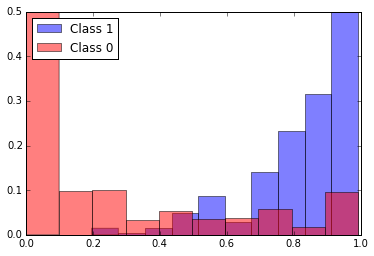

In [45]:
proba = clf.predict_proba(X_test)[:, 1]

plt.hist(proba[y_test.reshape(-1)==1], color="blue", label="Class 1", normed=True, alpha=0.5)
plt.hist(proba[y_test.reshape(-1)!=1], color="red", label="Class 0", normed=True, alpha=0.5)
plt.ylim(0, 0.5)
plt.legend(loc="upper left")

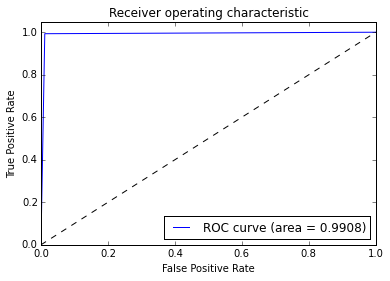

In [13]:
y_score = clf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.reshape(-1), y_score, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Get reconstructible events

In [14]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(0, 2000):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

In [15]:
from MarginLinearRegression import *
rmlr = RobustMarginLinearRegression(2)

In [16]:
from Y_views import *
all_dists = []
all_scores = []
all_labels = []
all_ks = []
all_bs = []

for event_id in reconstructible_events.keys():
    
    for track_id in [2.0, 3.0]:#reconstructible_events[event_id]:
    
        event = all_hits[all_hits['event'] == event_id]
        event = modify_for_yz_analysis_1_2(event)
        
        track = event[event.TrackID == track_id]
        false_track = event[event.TrackID != track_id]
        
        if len(track) == 0:
            continue
        
        mixed_track = pandas.concat([track[track.StatNb == 1], false_track[false_track.StatNb == 2]], axis=0)
        
        if len(track.values) == 0:
            print event_id, track_id
            continue
            
        if len(false_track.values) == 0:
            print event_id, track_id
            continue
            
        if len(mixed_track.values) == 0:
            print event_id, track_id
            continue
        
        pos_labels = [1]*len(track)
        neg_labels = [0]*len(false_track)
        mixed_neg_labels = [0]*len(mixed_track)
        
        rmlr = RobustMarginLinearRegression(2)
        score, lr = rmlr.fit(track)
        
        mixed_rmlr = RobustMarginLinearRegression(2)
        mixed_score, mixed_lr = mixed_rmlr.fit(mixed_track)
        
        all_scores += [score]*(len(track) + len(false_track)) + [mixed_score]*(len(mixed_track))
        
        track_dists = rmlr.dist2track(track)[:, 0]
        false_track_dists = rmlr.dist2track(false_track)[:, 0]
        mixed_track_dists = mixed_rmlr.dist2track(mixed_track)[:, 0]
        
        all_dists += list(track_dists) + list(false_track_dists) + list(mixed_track_dists)
        all_labels += pos_labels + neg_labels + mixed_neg_labels
        
        all_ks += [lr.coef_[0,0]]*(len(track) + len(false_track)) + [mixed_lr.coef_[0,0]]*(len(mixed_track))
        all_bs += [lr.intercept_[0]]*(len(track) + len(false_track)) + [mixed_lr.intercept_[0]]*(len(mixed_track))

In [17]:
data_test = pandas.DataFrame()
data_test['dist'] = all_dists
data_test['score'] = all_scores
data_test['score_div_dist'] = data_test['score'].values / data_test['dist'].values
data_test['slope'] = all_ks
data_test['intercept'] = all_bs
data_test['label'] = all_labels

In [18]:
X_test_test = data_test[['dist', 'score', 'score_div_dist', 'slope', 'intercept']].values 
y_test_test = data_test[['label']].values

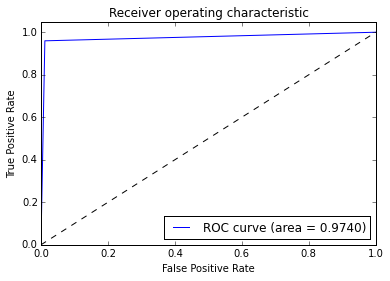

In [19]:
y_score = clf.predict(X_test_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test_test.reshape(-1), y_score, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")